In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import pyplot

# Load the dataset
train_data = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv")

print(train_data.head(5))
train_data.describe()

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [23]:
print('TRAIN SET MISSING VALUES:')
print(train_data.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test_data.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [24]:
print('TRAIN NON UNIQUE VALUES')
print(train_data.nunique())

TRAIN NON UNIQUE VALUES
PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64


In [25]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Text(0.5, 1.0, 'Target distribution')

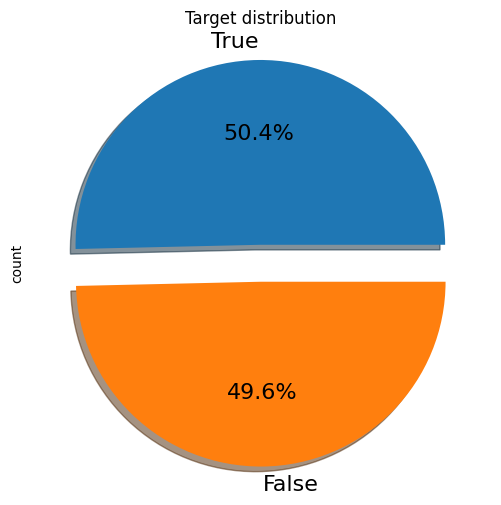

In [26]:
# Figure size
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

# Pie plot
train_data['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")


Text(0.5, 0, 'Age (years)')

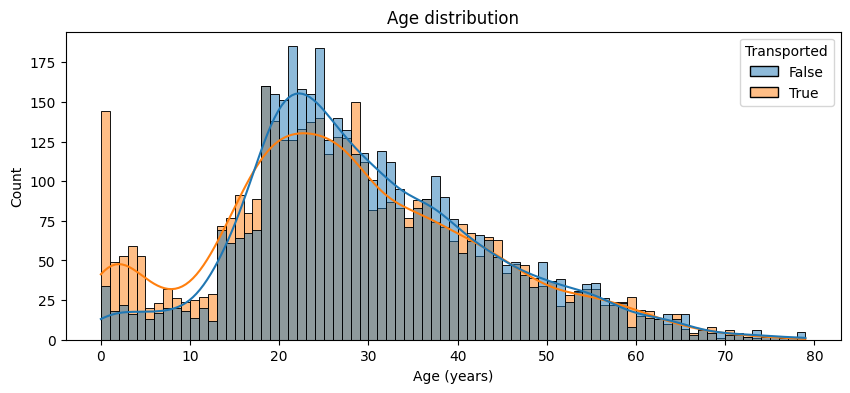

In [27]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train_data, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

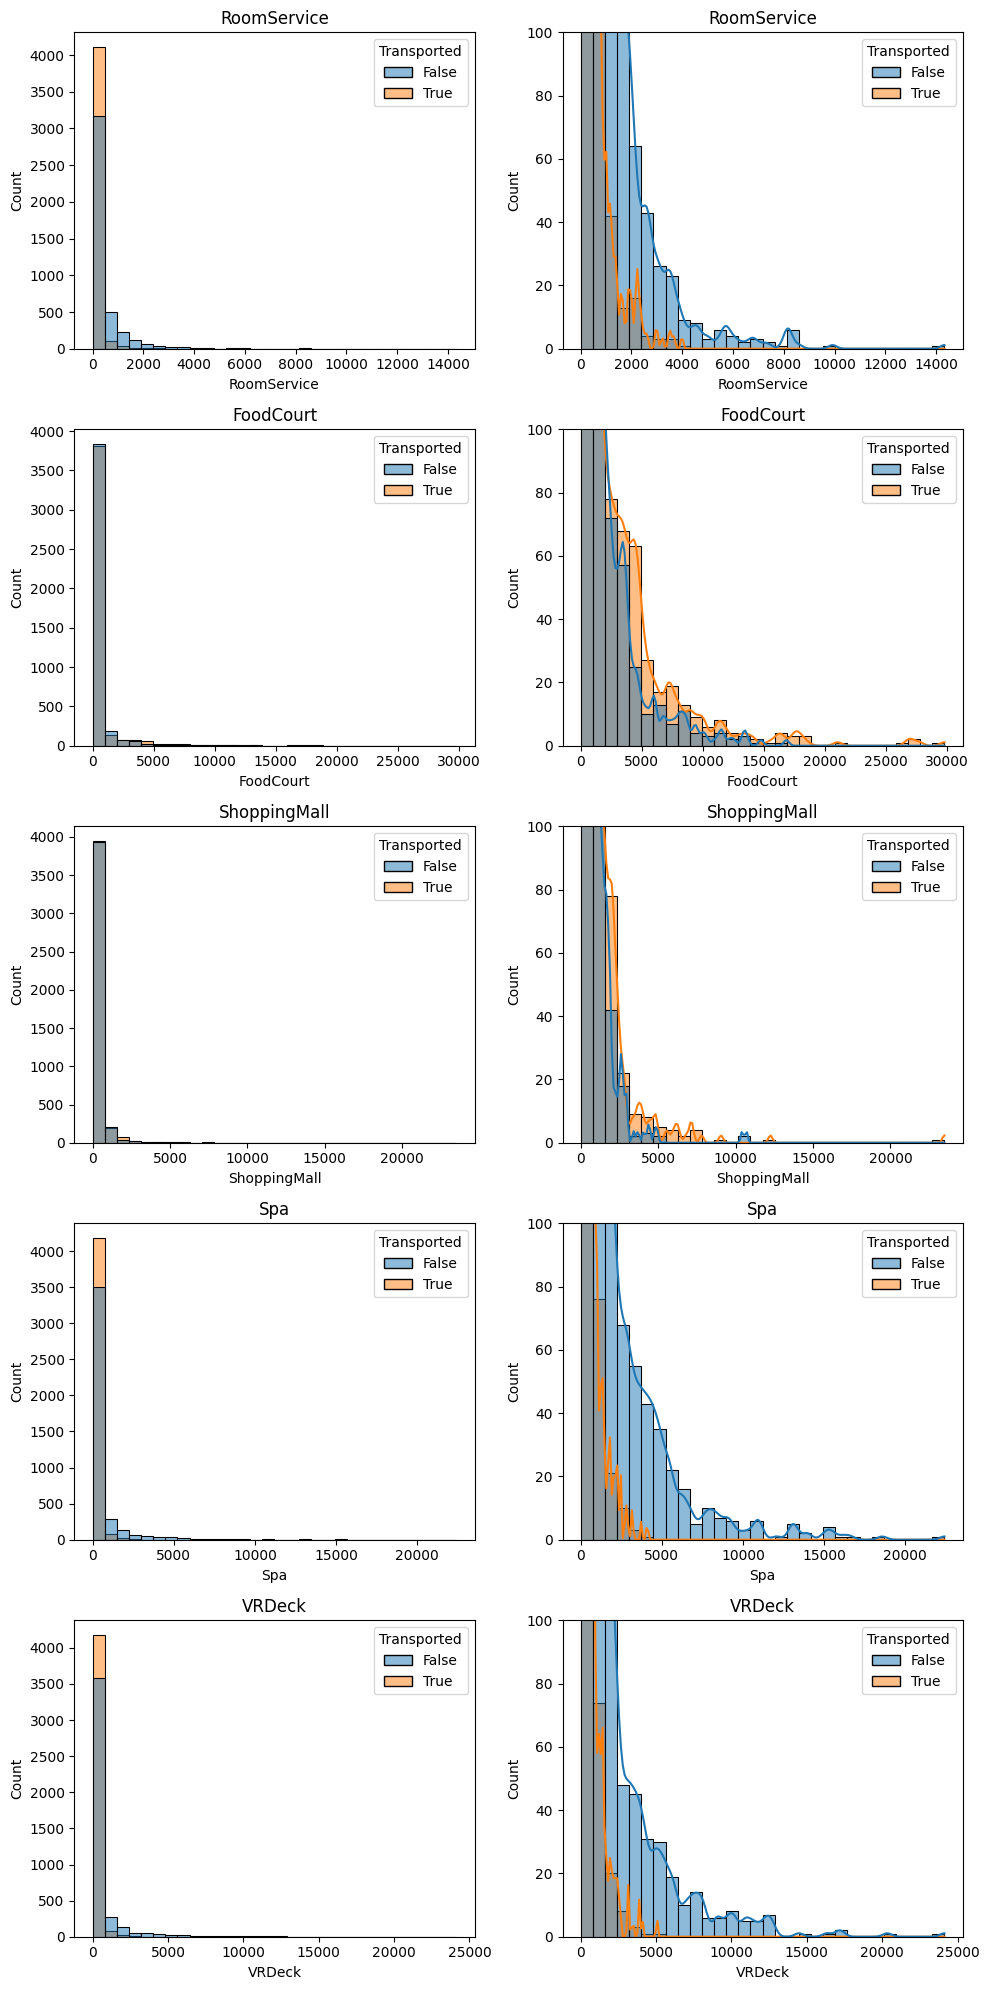

In [29]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_data, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_data, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

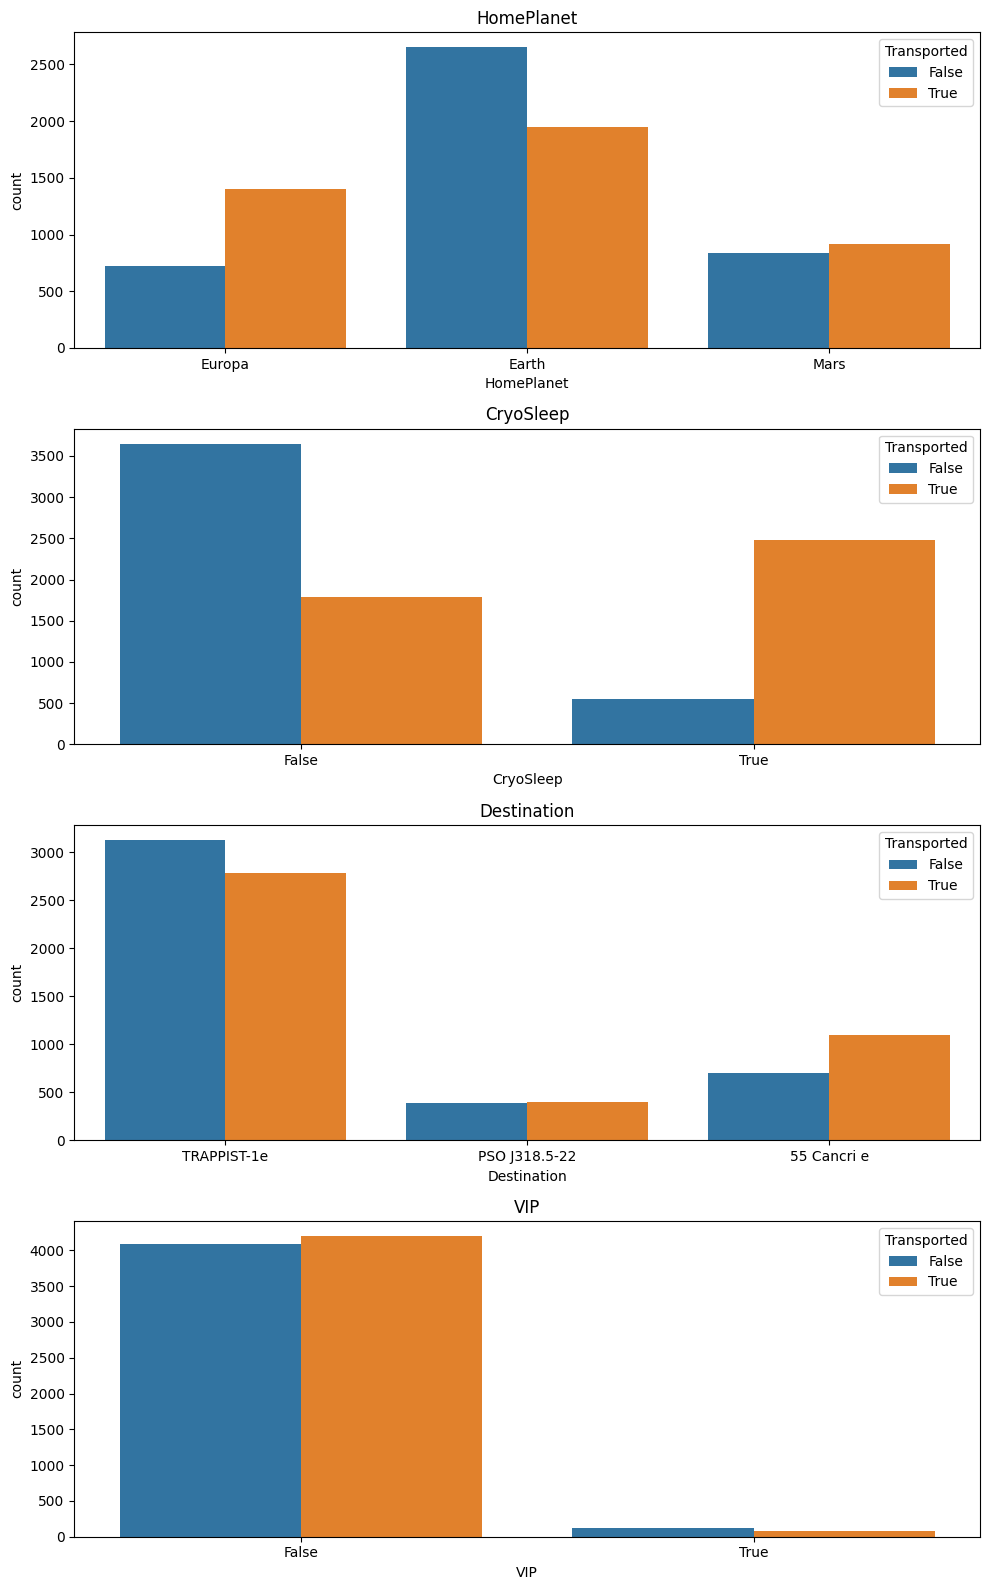

In [31]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train_data, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [32]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train_data[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


C:\Users\jayme\AppData\Local\Temp\ipykernel_10436\3612461272.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Age_0-12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_data.loc[train_data['Age']<=12,'Age_group']='Age_0-12'
C:\Users\jayme\AppData\Local\Temp\ipykernel_10436\3612461272.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Age_0-12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_data.loc[test_data['Age']<=12,'Age_group']='Age_0-12'


Text(0.5, 1.0, 'Age group distribution')

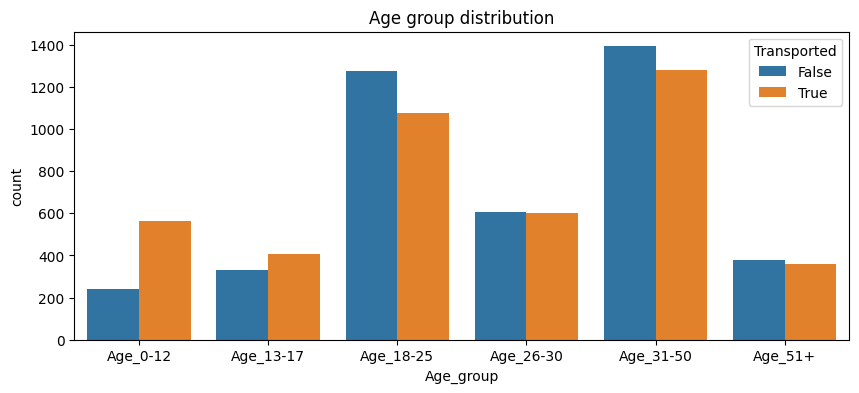

In [33]:
# New features - train_dataing set
train_data['Age_group']=np.nan
train_data.loc[train_data['Age']<=12,'Age_group']='Age_0-12'
train_data.loc[(train_data['Age']>12) & (train_data['Age']<18),'Age_group']='Age_13-17'
train_data.loc[(train_data['Age']>=18) & (train_data['Age']<=25),'Age_group']='Age_18-25'
train_data.loc[(train_data['Age']>25) & (train_data['Age']<=30),'Age_group']='Age_26-30'
train_data.loc[(train_data['Age']>30) & (train_data['Age']<=50),'Age_group']='Age_31-50'
train_data.loc[train_data['Age']>50,'Age_group']='Age_51+'

# New features - test set
test_data['Age_group']=np.nan
test_data.loc[test_data['Age']<=12,'Age_group']='Age_0-12'
test_data.loc[(test_data['Age']>12) & (test_data['Age']<18),'Age_group']='Age_13-17'
test_data.loc[(test_data['Age']>=18) & (test_data['Age']<=25),'Age_group']='Age_18-25'
test_data.loc[(test_data['Age']>25) & (test_data['Age']<=30),'Age_group']='Age_26-30'
test_data.loc[(test_data['Age']>30) & (test_data['Age']<=50),'Age_group']='Age_31-50'
test_data.loc[test_data['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train_data, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

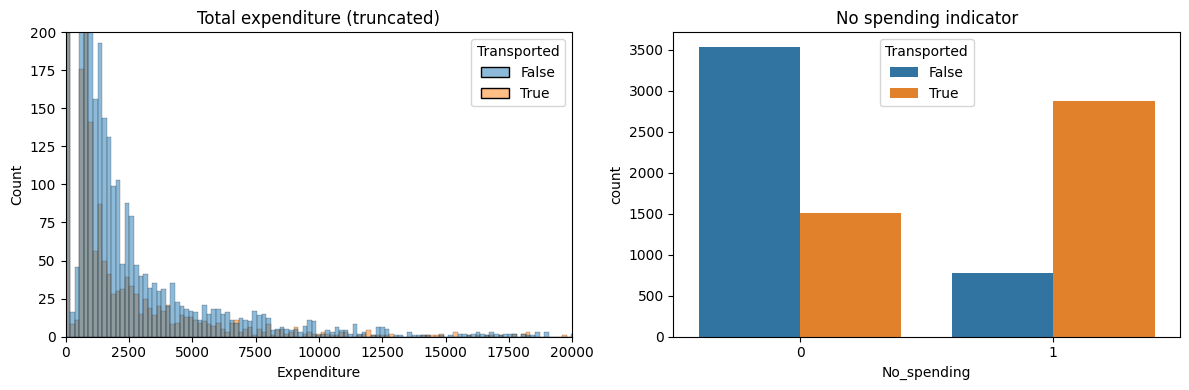

In [34]:
# New features - training set
train_data['Expenditure']=train_data[exp_feats].sum(axis=1)
train_data['No_spending']=(train_data['Expenditure']==0).astype(int)

# New features - test set
test_data['Expenditure']=test_data[exp_feats].sum(axis=1)
test_data['No_spending']=(test_data['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_data, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

C:\Users\jayme\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\jayme\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


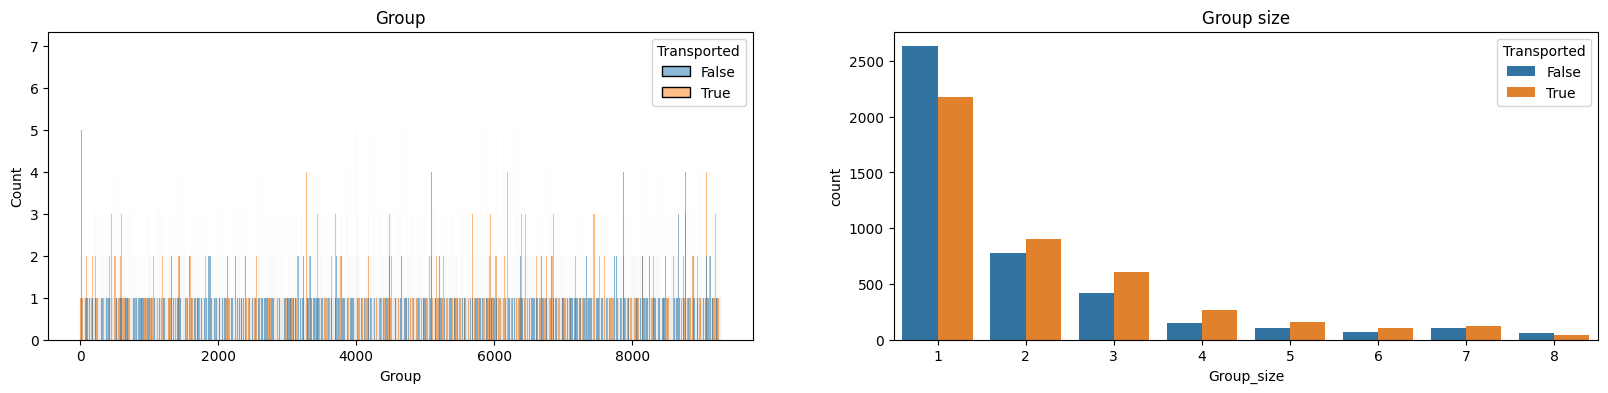

In [37]:
# New feature - Group
train_data['Group'] = train_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_data['Group'] = test_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train_data['Group_size']=train_data['Group'].map(lambda x: pd.concat([train_data['Group'], test_data['Group']]).value_counts()[x])
test_data['Group_size']=test_data['Group'].map(lambda x: pd.concat([train_data['Group'], test_data['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train_data, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

(0.0, 3000.0)

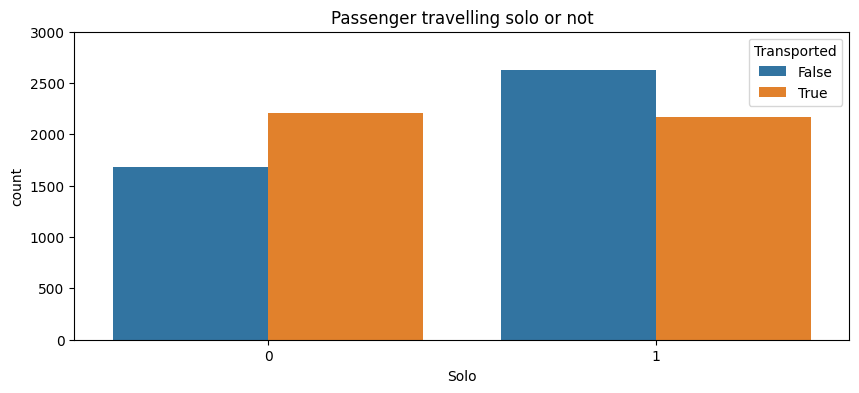

In [38]:
# New feature
train_data['Solo']=(train_data['Group_size']==1).astype(int)
test_data['Solo']=(test_data['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train_data, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

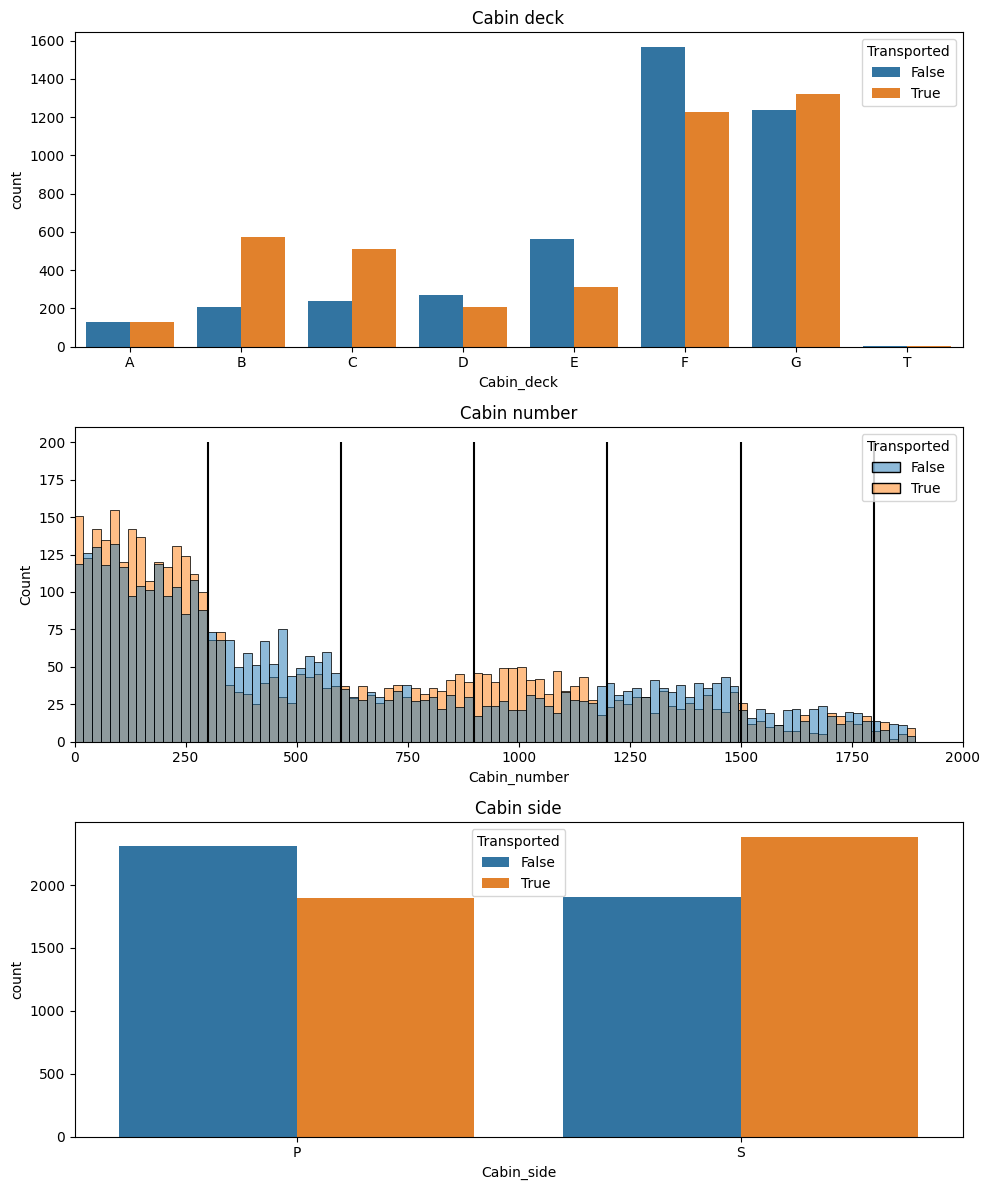

In [39]:
# Replace NaN's with outliers for now (so we can split feature)
train_data['Cabin'].fillna('Z/9999/Z', inplace=True)
test_data['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train_data['Cabin_deck'] = train_data['Cabin'].apply(lambda x: x.split('/')[0])
train_data['Cabin_number'] = train_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train_data['Cabin_side'] = train_data['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test_data['Cabin_deck'] = test_data['Cabin'].apply(lambda x: x.split('/')[0])
test_data['Cabin_number'] = test_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_data['Cabin_side'] = test_data['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train_data.loc[train_data['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train_data.loc[train_data['Cabin_number']==9999, 'Cabin_number']=np.nan
train_data.loc[train_data['Cabin_side']=='Z', 'Cabin_side']=np.nan
test_data.loc[test_data['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test_data.loc[test_data['Cabin_number']==9999, 'Cabin_number']=np.nan
test_data.loc[test_data['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train_data, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train_data, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train_data, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

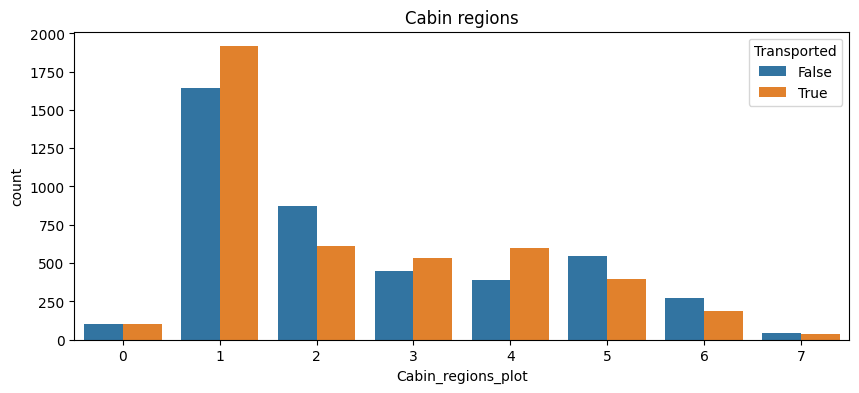

In [40]:
# New features - training set
train_data['Cabin_region1']=(train_data['Cabin_number']<300).astype(int)   # one-hot encoding
train_data['Cabin_region2']=((train_data['Cabin_number']>=300) & (train_data['Cabin_number']<600)).astype(int)
train_data['Cabin_region3']=((train_data['Cabin_number']>=600) & (train_data['Cabin_number']<900)).astype(int)
train_data['Cabin_region4']=((train_data['Cabin_number']>=900) & (train_data['Cabin_number']<1200)).astype(int)
train_data['Cabin_region5']=((train_data['Cabin_number']>=1200) & (train_data['Cabin_number']<1500)).astype(int)
train_data['Cabin_region6']=((train_data['Cabin_number']>=1500) & (train_data['Cabin_number']<1800)).astype(int)
train_data['Cabin_region7']=(train_data['Cabin_number']>=1800).astype(int)

# New features - test set
test_data['Cabin_region1']=(test_data['Cabin_number']<300).astype(int)   # one-hot encoding
test_data['Cabin_region2']=((test_data['Cabin_number']>=300) & (test_data['Cabin_number']<600)).astype(int)
test_data['Cabin_region3']=((test_data['Cabin_number']>=600) & (test_data['Cabin_number']<900)).astype(int)
test_data['Cabin_region4']=((test_data['Cabin_number']>=900) & (test_data['Cabin_number']<1200)).astype(int)
test_data['Cabin_region5']=((test_data['Cabin_number']>=1200) & (test_data['Cabin_number']<1500)).astype(int)
test_data['Cabin_region6']=((test_data['Cabin_number']>=1500) & (test_data['Cabin_number']<1800)).astype(int)
test_data['Cabin_region7']=(test_data['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train_data['Cabin_regions_plot']=(train_data['Cabin_region1']+2*train_data['Cabin_region2']+3*train_data['Cabin_region3']+4*train_data['Cabin_region4']+5*train_data['Cabin_region5']+6*train_data['Cabin_region6']+7*train_data['Cabin_region7']).astype(int)
sns.countplot(data=train_data, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train_data.drop('Cabin_regions_plot', axis=1, inplace=True)


Text(0.5, 1.0, 'Family size')

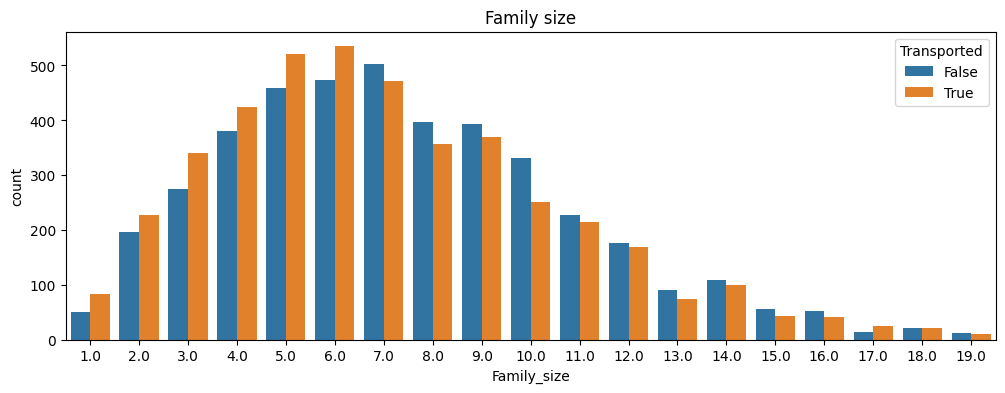

In [41]:
# Replace NaN's with outliers for now (so we can split feature)
train_data['Name'].fillna('Unknown Unknown', inplace=True)
test_data['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train_data['Surname']=train_data['Name'].str.split().str[-1]
test_data['Surname']=test_data['Name'].str.split().str[-1]

# New feature - Family size
train_data['Family_size']=train_data['Surname'].map(lambda x: pd.concat([train_data['Surname'],test_data['Surname']]).value_counts()[x])
test_data['Family_size']=test_data['Surname'].map(lambda x: pd.concat([train_data['Surname'],test_data['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train_data.loc[train_data['Surname']=='Unknown','Surname']=np.nan
train_data.loc[train_data['Family_size']>100,'Family_size']=np.nan
test_data.loc[test_data['Surname']=='Unknown','Surname']=np.nan
test_data.loc[test_data['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train_data.drop('Name', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train_data, x='Family_size', hue='Transported')
plt.title('Family size')


In [42]:
# Labels and features
y=train_data['Transported'].copy().astype(int)
X=train_data.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test_data], axis=0).reset_index(drop=True)

In [43]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


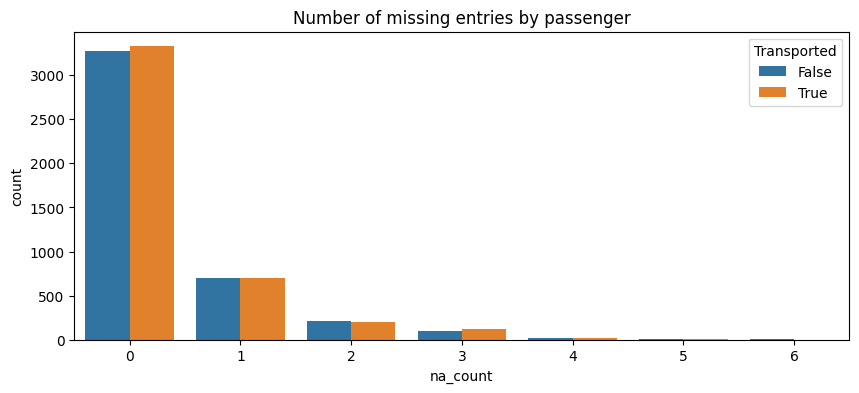

In [44]:
# Countplot of number of missing values by passenger
train_data['na_count']=train_data.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train_data, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train_data.drop('na_count', axis=1, inplace=True)

In [45]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Number of unique home planets per group')

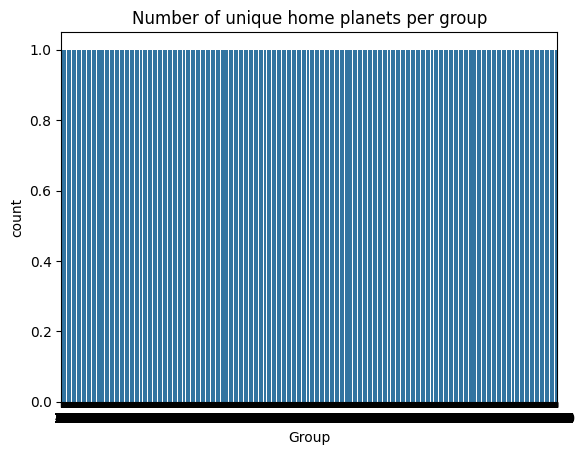

In [46]:
# Countplot of unique values
sns.countplot((GHP_gb>0).sum(axis=1))
plt.title('Number of unique home planets per group')

In [47]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


<Axes: xlabel='Cabin_deck', ylabel='HomePlanet'>

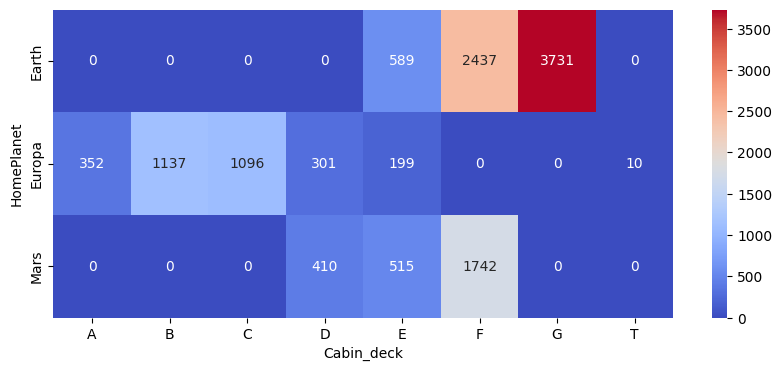

In [48]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [49]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


Text(0.5, 1.0, 'Number of unique planets per surname')

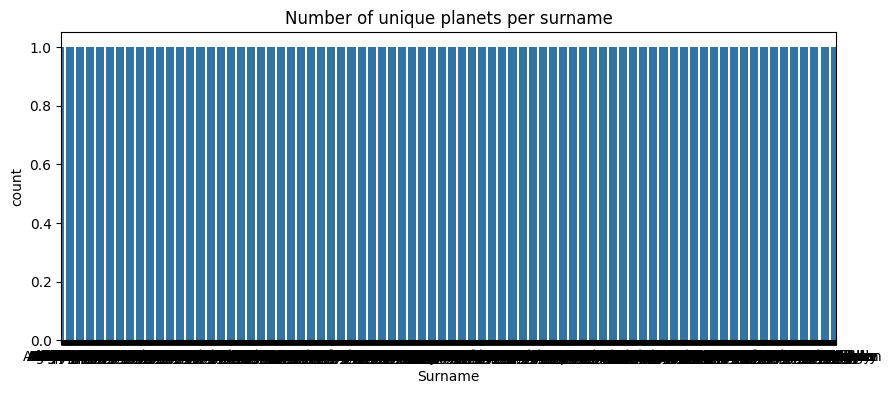

In [50]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

In [51]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [52]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]


,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


<Axes: xlabel='HomePlanet', ylabel='Destination'>

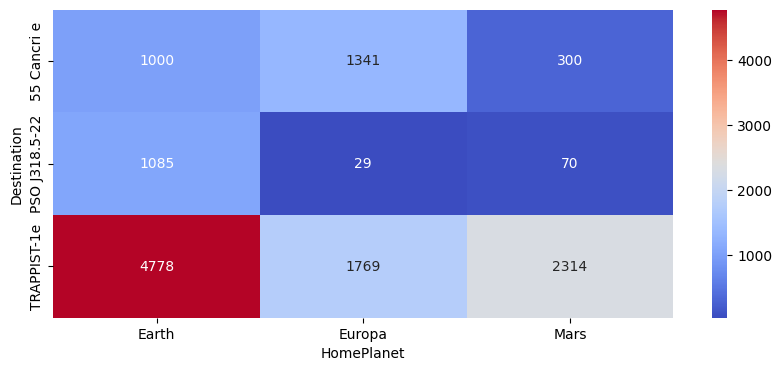

In [53]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [54]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


In [55]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())


#Destination missing values before: 274
#Destination missing values after: 0


Text(0.5, 1.0, 'Number of unique surnames by group')

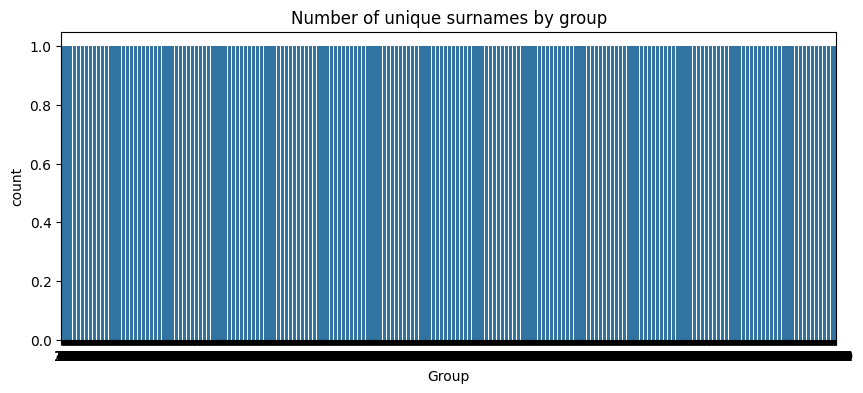

In [56]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')

In [57]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


In [58]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

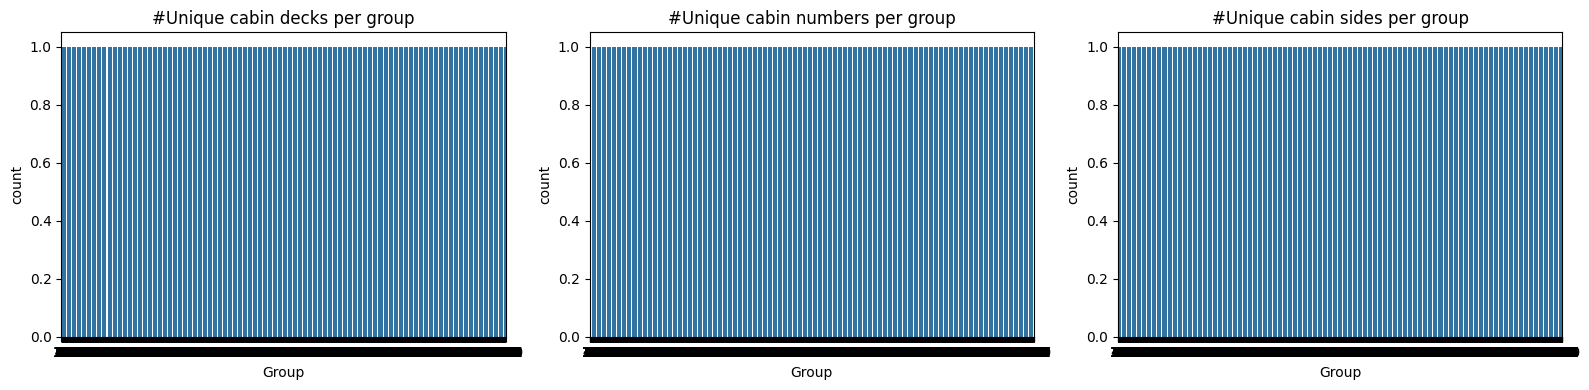

In [59]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('#Unique cabin sides per group')
fig.tight_layout()


In [ ]:
# Split the resampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=1)

In [ ]:
# Define a Keras neural network model
def create_keras_model():
    model = keras.Sequential([
        layers.Dense(128, input_dim=X_train.shape[1], activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

keras_classifier = KerasClassifier(build_fn=create_keras_model, epochs=50, batch_size=64, verbose=1)


In [ ]:
# Ensemble Learning (Soft Voting)
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=1)),
    ("Decision Tree", DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=1)),
    ("SVM (RBF Kernel)", SVC(kernel="rbf", C=1.0, gamma=0.2, probability=True, random_state=1)),
    ("Logistic Regression", LogisticRegression(random_state=1)),
    ("Keras Neural Network", keras_classifier),
]

ensemble = VotingClassifier(models, voting="soft")
# Train the ensemble model
ensemble.fit(X_train, y_train)


Epoch 1/50


d:\Python39\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


14/14 [==============================] - 1s 2ms/step - loss: 0.7197 - accuracy: 0.5080
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.5558
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.6048
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.6663
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6273 - accuracy: 0.6743
Epoch 6/50
14/14 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7062
Epoch 7/50
14/14 [==============================] - 0s 1ms/step - loss: 0.5522 - accuracy: 0.7608
Epoch 8/50
14/14 [==============================] - 0s 1ms/step - loss: 0.5162 - accuracy: 0.7882
Epoch 9/50
14/14 [==============================] - 0s 1ms/step - loss: 0.4929 - accuracy: 0.7870
Epoch 10/50
14/14 [==============================] - 0s 1ms/step - loss: 0.4737 - accuracy: 0.7870
Epoch 11/50
14/14 [===========

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(max_depth=5,
                                                     random_state=1)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=1)),
                             ('Decision Tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=4,
                                                     random_state=1)),
                             ('SVM (RBF Kernel)',
                              SVC(gamma=0.2, probability=True, random_state=1)),
                             ('Logistic Regression',
                              LogisticRegression(random_state=1)),
                             ('Keras Neural Network',
                              KerasClassifier(batch_size=64, build_fn=<function create_keras_model at 0x000001FB2BA82DC0>, epochs=50))],
                 voting='soft')

In [ ]:
# Evaluate the ensemble model on the validation set
ensemble_accuracy = accuracy_score(y_val, ensemble.predict(X_val))
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")

# Get probability estimates for test data
test_probabilities = ensemble.predict_proba(X_test)[:, 1]
print(test_probabilities)


4/4 [==============================] - 0s 1ms/step
Ensemble Model Accuracy: 0.8227272727272728
7/7 [==============================] - 0s 3ms/step
[0.14047731 0.30883058 0.22848652 0.16453926 0.67884317 0.33472496
 0.72074967 0.21287878 0.72702998 0.17609214 0.15052885 0.34985033
 0.95552897 0.27870088 0.90858163 0.90071106 0.2368534  0.15998142
 0.67679576 0.34420313 0.44180722 0.70175247 0.94691499 0.48161421
 0.88536838 0.14155759 0.96216343 0.16470075 0.48751941 0.15871634
 0.22238997 0.20780239 0.59113216 0.57712497 0.46369792 0.15987167
 0.69485834 0.74356573 0.14758556 0.15052885 0.13431201 0.44593966
 0.13731942 0.91922957 0.8599435  0.14758556 0.37839692 0.15052885
 0.84714233 0.58452371 0.51749353 0.24430962 0.89590818 0.80507582
 0.21540807 0.08796967 0.13817173 0.14758556 0.15066253 0.96440846
 0.18353627 0.30099296 0.16016886 0.76890905 0.77304495 0.91682272
 0.72702998 0.36361677 0.51382315 0.82010585 0.73715687 0.15998142
 0.73540969 0.48448866 0.96579838 0.60496635 0.150

In [ ]:
# Apply a threshold to convert probabilities to binary predictions
threshold = 0.6
test_predictions = (test_probabilities > threshold).astype(int)

# Save the test predictions to a CSV file
output = pd.DataFrame({"PassengerId": test_data["PassengerId"], "Survived": test_predictions})
output.to_csv("submission_ensemble_with_keras_random_oversampling.csv", index=False)
print("Test predictions saved to submission_ensemble_with_keras.csv")

Test predictions saved to submission_ensemble_with_keras.csv
